In [1]:
# filtered or not
# word2vec choice
# with images or not.
# pca


# main function is f(user, business)
# user2avgVec # inclusive of current business
# user2avgHistVec # exclusive of current business
# business2avgVec # inclusive of current user
# business2avgHistVec # exclusive of current user

# with or without t filtered json?
# with or without currents?
# with or without pics?

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
from collections import defaultdict
from bs4 import BeautifulSoup  
import requests
import zipfile
import io
import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from nltk.tokenize import word_tokenize
nltk.download('stopwords')

#import geopandas as gpd|
#import shapely
import gensim
import tqdm
import tensorflow as tf
import keras

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding

# Load the Drive helper and mount
#from google.colab import drive
#mounted_path_folder = '/content/drive'
#drive.mount(mounted_path_folder, force_remount=True)

import sys
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder
path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))
sys.path.insert(0, path_folder+"/src/features/")
import util

from word2vec_recipe import *


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import tqdm

In [5]:
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder
path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))


In [6]:
import pickle

vocab_column_names = ["ingredients"]+["name"]
file_name_word2vec = "word2vec_"+("_".join(vocab_column_names))+".pkl"
path_file_word2vec = os.path.join(path_folder, "data","temp",file_name_word2vec)
with open(path_file_word2vec, "rb") as f:
    recipe_word2vec = pickle.load(f)

vocab_column_names = ["ingredients"]#+["name"]
file_name_tfidf = "tfidf_"+("_".join(vocab_column_names))+".pkl"
path_file_tfidf = os.path.join(path_folder, "data","temp",file_name_tfidf)
with open(path_file_tfidf, "rb") as f:
    recipe_tfidf = pickle.load(f)

DATASET_VERSION = ["FULL", "FILTER"][1]  
DROP_ONE_TIME_APPEARANCES = True
DROP_SEPARATED_ONE_TIME_APPEARANCES = False
USING_PICS = False

if DATASET_VERSION == "FILTER":
    path_folder_data = os.path.join(path_folder,"data","raw","filter_all_t.json")
else:
    path_folder_data = os.path.join(path_folder,"data","raw","image_review_all.json")

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
data = []
with open(path_folder_data) as f:
    for line in tqdm.tqdm(f):
        data.append(eval(line))
    f.close()

1it [00:16, 16.95s/it]


In [8]:
# Filter or Full
# Pics or no Pics
# Drop one-time-appearing business_ids/user_ids: (seperately, or conjoined?) (for example, the business_id is 1-time, but the user_id has already appeared many times before)

In [9]:
if DATASET_VERSION == "FILTER":
    train_reviews = (data[0]["train"])
    test_reviews = (data[0]["test"])
else:
    train_reviews = data
# 3 tables:
# 1 for business_id, user_id, review_text, rating
# 1 for pics: business_id, user_id, pic
# 1 for external history review: business_id, user_id, review_text

#reviews_df = pd.DataFrame(data=None, columns=["business_id","user_id","rating","review_text"])
#history_reviews_df = pd.DataFrame(data=None, columns=["business_id","user_id","review_text"])
#pics_df = pd.DataFrame(data=None, columns=["business_id","user_id","pics"])

reviews_df_business_id_column_list = []
reviews_df_user_id_column_list = []
reviews_df_rating_column_list = []
reviews_df_review_text_column_list = []

history_reviews_df_business_id_column_list = []
history_reviews_df_user_id_column_list = []
history_reviews_df_review_text_column_list = []

pics_df_business_id_column_list = []
pics_df_user_id_column_list = []
pics_df_pics_column_list = []


for review in tqdm.tqdm(train_reviews):
    temp_business_id = None
    temp_user_id = None
    temp_rating = None
    temp_review_text = None
    temp_pics = None
    temp_history_reviews = None

    if "business_id" in review:
        temp_business_id = review["business_id"]
    if "user_id" in review:
        temp_user_id = review["user_id"]
    if "rating" in review:
        temp_rating = review["rating"]
    if "review_text" in review:
        temp_review_text = review["review_text"]
    if "pics" in review:
        temp_pics = review["pics"]
        if DATASET_VERSION == "FULL":
             temp_pics = [x["id"] for x in (temp_pics)]
    if "history_reviews" in review:
        temp_history_reviews = review["history_reviews"]
    
    reviews_df_business_id_column_list.append(temp_business_id)
    reviews_df_user_id_column_list.append(temp_user_id)
    reviews_df_rating_column_list.append(temp_rating)
    reviews_df_review_text_column_list.append(temp_review_text)

    if USING_PICS == True:
        if (temp_pics is None)==False:
            temp_pics_len = len(temp_pics)
            pics_df_business_id_column_list.extend([temp_business_id for _ in range(temp_pics_len)])
            pics_df_user_id_column_list.extend([temp_user_id for _ in range(temp_pics_len)])
            pics_df_pics_column_list.extend(temp_pics)

    #if (temp_history_reviews is None)==False:
    #    temp_history_reviews_len = len(temp_history_reviews)
    #    history_reviews_df_business_id_column_list.extend([x[0].split("_")[1] for x in temp_history_reviews])
    #    history_reviews_df_user_id_column_list.extend([temp_user_id for _ in range(temp_history_reviews_len)])
    #    history_reviews_df_review_text_column_list.extend([x[1] for x in temp_history_reviews])


reviews_df = pd.DataFrame()
reviews_df["business_id"] = reviews_df_business_id_column_list
reviews_df["user_id"] = reviews_df_user_id_column_list
reviews_df["rating"] = reviews_df_rating_column_list
reviews_df["review_text"] = reviews_df_review_text_column_list

#history_reviews_df = pd.DataFrame()
#history_reviews_df["business_id"] = history_reviews_df_business_id_column_list
#history_reviews_df["user_id"] = history_reviews_df_user_id_column_list
#history_reviews_df["review_text"] = history_reviews_df_review_text_column_list
if USING_PICS == True:
    pics_df = pd.DataFrame()
    pics_df["business_id"] = pics_df_business_id_column_list
    pics_df["user_id"] = pics_df_user_id_column_list
    pics_df["pics"] = pics_df_pics_column_list


100%|████████████████████████████████████████████████████████████████████████| 87013/87013 [00:00<00:00, 260065.65it/s]


In [10]:
from sklearn.preprocessing import LabelEncoder

business_id_label_encoder = LabelEncoder()
user_id_label_encoder = LabelEncoder()

business_id_label_encoder.fit(reviews_df["business_id"])
user_id_label_encoder.fit(reviews_df["user_id"])

reviews_df["business_id"] = business_id_label_encoder.transform(reviews_df["business_id"])
reviews_df["user_id"] = user_id_label_encoder.transform(reviews_df["user_id"])

In [11]:
del data
del reviews_df_business_id_column_list
del reviews_df_user_id_column_list
del reviews_df_rating_column_list
del reviews_df_review_text_column_list
del train_reviews

In [12]:
from keras.applications.vgg16 import VGG16
#vggnet_model = VGG16()
url_header_pics = "https://lh5.googleusercontent.com/p/"
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from PIL import Image
import requests
from io import BytesIO

path_file_name = os.path.join(path_folder, "data", "temp","business_user2picVec.pkl")

class Dataset_Embedding_Mapper_Pics:
    def __init__(self, recipe_word2vec, recipe_tfidf, temp_df, file_name_suffix):
        # temp_df is pics_df
        assert all((x in list(temp_df.columns)) for x in ["pics","business_id","user_id"])
        self.recipe_word2vec = recipe_word2vec
        self.recipe_tfidf = recipe_tfidf
        self.temp_df = temp_df
        self.path_file_business_user2vec = os.path.join(path_folder, "data", "temp","business_user2"+file_name_suffix+".pkl")
        self.path_file_user_business2vec = os.path.join(path_folder, "data", "temp","user_business2"+file_name_suffix+".pkl")
        self.business_user2vec = None
        self.user_business2vec = None
        self.__url_header_pics = "https://lh5.googleusercontent.com/p/"
        self.set_vggnet_model()
    def set_vggnet_model(self):
        vggnet_model = VGG16()
        self.vggnet_model = vggnet_model
        return vggnet_model
    def build_dataset_embedding_mappers(self):
        pics_df = self.temp_df
        batch_size = 1000
        business_user2picVec = dict()
        user_business2picVec = dict()
        for i in (range(0, (pics_df["pics"].shape[0]), batch_size)):
            self.business_user2vec = business_user2picVec
            self.user_business2vec = user_business2picVec
            self.write_dataset_embedding_mappers()

            temp_start_i = i
            temp_end_i = min(i + batch_size, pics_df["pics"].shape[0])
            chunk_iter_size = temp_end_i - temp_start_i
            # for each image url in the batch, check if url works, insert into broken links if it doesnt
            # if url works, continue to preprocess and resize and then stack it into an array of shape (Q, 224, 224, 3), where Q <= Batch_size, and batch_size - Q = number of broken urls
            # also keep a list of unbroken indices (ordered)
            # Then put array of shape (Q, 24, 24, 3) into vggnet and into decode_predictions, call the output by decoded
            # the decoded output dimensions should be Q, 100, 3
            # get only the top_n suggested words, making the decoded output dimensions as Q, top_n, 3
            # get only the images where the top_n suggested words actually exist in word2vec, reducing the height as R where R <= Q
            # update the unbroken indices accordingly.


            unbroken_indices = list(range(temp_start_i, temp_end_i))
            broken_indices = []
            #
            vggnet_model_input = []
            for batch_i in range(0, chunk_iter_size):
                try:
                    pic_url = pics_df["pics"][batch_i + temp_start_i]
                    url = self.__url_header_pics + pic_url
                    response = requests.get(url)
                    image = Image.open(BytesIO(response.content))
                    image = np.array(image)
                    image =  np.array(Image.fromarray(image).resize((224, 224), Image.NEAREST))
                    try:
                        assert image.shape == (224, 224, 3)
                    except:
                        assert False
                    vggnet_model_input.append(image)
                except:
                    broken_indices.append(batch_i)

            for broken_index in broken_indices[::-1]: # needs to be done backwards to avoid changing the index mapping after each index is removed
                unbroken_indices.pop(broken_index)
            broken_indices = []
            vggnet_model_input = np.array(vggnet_model_input)
            assert len(vggnet_model_input.shape) == 4
            assert list(vggnet_model_input.shape)[1:] == [224, 224, 3]
            assert len(unbroken_indices) == vggnet_model_input.shape[0]
            encoded_predictions = self.vggnet_model.predict(vggnet_model_input) #, verbose=0)
            decoded_output = decode_predictions(encoded_predictions)
            
            top_n = 1
            final_embeddings = []
            for decoded_i in range(len(decoded_output)):
                temp_vecs = []
                temp_labels_top_n = [label[1] for label in decoded_output[decoded_i][:top_n]]
                for word in temp_labels_top_n:
                    if word not in self.recipe_word2vec.wv: continue;
                    if word not in self.recipe_tfidf.vocab2idx: continue;
                    embedding = self.recipe_word2vec.wv[word]
                    temp_vecs.append((embedding))
                if temp_vecs == []:
                    # if none of the top n predicted words of a given image are found in word2vec model, skip the image altogether
                    broken_indices.append(decoded_i)
                else:
                    final_embeddings.append(temp_vecs)
            
            for broken_index in broken_indices[::-1]:
                unbroken_indices.pop(broken_index)
            assert len(final_embeddings) == len(unbroken_indices)
            assert len(final_embeddings) != 0
            for k in range(len(final_embeddings)):
                pic_idx = unbroken_indices[k]

                temp_row = pics_df.iloc[pic_idx]
                temp_business_id = (temp_row["business_id"])
                temp_user_id = (temp_row["user_id"])
                temp_pic_url = (temp_row["pics"])
                temp_pic_vecs = final_embeddings[k]
                # cannot add within the function, because we need to keep information about the amount (which may decrease within the function because of stop words)
                if temp_pic_vecs != []:
                    if temp_business_id in business_user2picVec:
                        if temp_user_id in business_user2picVec[temp_business_id]:
                            business_user2picVec[temp_business_id][temp_user_id] += temp_pic_vecs
                        else:
                            business_user2picVec[temp_business_id][temp_user_id] = temp_pic_vecs
                    else:
                        business_user2picVec[temp_business_id] = dict()
                        business_user2picVec[temp_business_id][temp_user_id] = temp_pic_vecs
                    
                    if temp_user_id in user_business2picVec:
                        if temp_business_id in user_business2picVec[temp_user_id]:
                            user_business2picVec[temp_user_id][temp_business_id] += temp_pic_vecs
                        else:
                            user_business2picVec[temp_user_id][temp_business_id] = temp_pic_vecs
                    else:
                        user_business2picVec[temp_user_id] = dict()
                        user_business2picVec[temp_user_id][temp_business_id] = temp_pic_vecs
        self.business_user2vec = business_user2picVec
        self.user_business2vec = user_business2picVec
    def read_dataset_embedding_mappers(self, path_file_business_user2vec=None, path_file_user_business2vec=None):
        if path_file_business_user2vec is None:
            path_file_business_user2vec = self.path_file_business_user2vec
        if path_file_user_business2vec is None:
            path_file_user_business2vec = self.path_file_user_business2vec
        with open(path_file_business_user2vec, "rb") as f:
            business_user2vec = pickle.load(f)
            f.close()
        with open(path_file_user_business2vec, "rb") as f:
            user_business2vec = pickle.load(f)
            f.close()
        self.business_user2vec = business_user2vec
        self.user_business2vec = user_business2vec
    def write_dataset_embedding_mappers(self, path_file_business_user2vec=None, path_file_user_business2vec=None):
        if path_file_business_user2vec is None:
            path_file_business_user2vec = self.path_file_business_user2vec
        if path_file_user_business2vec is None:
            path_file_user_business2vec = self.path_file_user_business2vec
        with open(path_file_business_user2vec, "wb") as f:
            pickle.dump(self.business_user2vec, f)
            f.close()
        with open(path_file_user_business2vec, "wb") as f:
            pickle.dump(self.user_business2vec, f)
            f.close()

In [13]:
import string
non_alphanumeric = string.punctuation # constant

class Dataset_Embedding_Mapper_Review_Text:
    def __init__(self, recipe_word2vec, recipe_tfidf, temp_df, file_name_suffix):
        # temp_df is reviews_df
        assert all((x in list(temp_df.columns)) for x in ["review_text","business_id","user_id"])
        self.recipe_word2vec = recipe_word2vec
        self.recipe_tfidf = recipe_tfidf
        self.temp_df = temp_df
        self.path_file_business_user2vec = os.path.join(path_folder, "data", "temp","business_user2"+file_name_suffix+".pkl")
        self.path_file_user_business2vec = os.path.join(path_folder, "data", "temp","user_business2"+file_name_suffix+".pkl")
        self.business_user2vec = None
        self.user_business2vec = None
        self.__non_alphanumeric = string.punctuation
        self.__stop_words = stopwords.words('english')+[""]
    def __clean_text(self, text):
        non_alphanumeric = string.punctuation
        text = text.lower()
        text = text.translate(str.maketrans(self.__non_alphanumeric, " "*len(non_alphanumeric)))
        return text
    def __reviewText2vecList(self, review_text):
        vec_list = []
        clean_review_text = self.__clean_text(review_text)
        for word in clean_review_text.split(" "):
            if word in self.__stop_words: continue;
            if word not in self.recipe_word2vec.wv: continue;
            if word not in self.recipe_tfidf.vocab2idx: continue;
            vec = self.recipe_word2vec.wv[word]
            vec_list.append(vec)
        return vec_list
    def __reviewText(self, review_text):
        word_list = []
        clean_review_text = self.__clean_text(review_text)
        for word in clean_review_text.split(" "):
            if word in self.__stop_words: continue;
            if word not in self.recipe_word2vec.wv: continue;
            if word not in self.recipe_tfidf.vocab2idx: continue;
            #vec = self.recipe_word2vec.wv[word]
            word_list.append(word)
        return word_list
    def build_dataset_embedding_mappers(self):
        reviews_df = self.temp_df
        business_user2reviewTextVec = dict()
        user_business2reviewTextVec = dict()
        for i in tqdm.tqdm(range(reviews_df.shape[0])):
            temp_row = reviews_df.iloc[i]
            temp_business_id = (temp_row["business_id"])
            temp_user_id = (temp_row["user_id"])
            temp_review_text = (temp_row["review_text"])
            temp_review_text_vecs = self.__reviewText2vecList(temp_review_text)
            # cannot add within the function, because we need to keep information about the amount (which may decrease within the function because of stop words)
            if temp_review_text_vecs != []:
                if temp_business_id not in business_user2reviewTextVec:
                    business_user2reviewTextVec[temp_business_id] = dict()
                business_user2reviewTextVec[temp_business_id][temp_user_id] = temp_review_text_vecs

                if temp_user_id not in user_business2reviewTextVec:
                    user_business2reviewTextVec[temp_user_id] = dict()
                user_business2reviewTextVec[temp_user_id][temp_business_id] = temp_review_text_vecs
        self.business_user2vec = business_user2reviewTextVec
        self.user_business2vec = user_business2reviewTextVec

    def build_dataset_cleaned_text_mappers(self):
        reviews_df = self.temp_df
        business_user2reviewText = dict()
        user_business2reviewText = dict()
        for i in tqdm.tqdm(range(reviews_df.shape[0])):
            temp_row = reviews_df.iloc[i]
            temp_business_id = (temp_row["business_id"])
            temp_user_id = (temp_row["user_id"])
            temp_review_text = (temp_row["review_text"])
            temp_review_text_cleaned = self.__reviewText(temp_review_text)
            temp_review_text_cleaned = " ".join(temp_review_text_cleaned)
            # cannot add within the function, because we need to keep information about the amount (which may decrease within the function because of stop words)
            if temp_review_text_cleaned != "":
                if temp_business_id not in business_user2reviewText:
                    business_user2reviewText[temp_business_id] = dict()
                business_user2reviewText[temp_business_id][temp_user_id] = temp_review_text_cleaned
                if temp_user_id not in user_business2reviewText:
                    user_business2reviewText[temp_user_id] = dict()
                user_business2reviewText[temp_user_id][temp_business_id] = None #temp_review_text_cleaned
        self.business_user2reviewText = (business_user2reviewText)
        self.user_business2reviewText = (user_business2reviewText)

    def read_dataset_embedding_mappers(self, path_file_business_user2vec=None, path_file_user_business2vec=None):
        if path_file_business_user2vec is None:
            path_file_business_user2vec = self.path_file_business_user2vec
        if path_file_user_business2vec is None:
            path_file_user_business2vec = self.path_file_user_business2vec
        with open(path_file_business_user2vec, "rb") as f:
            business_user2vec = pickle.load(f)
            f.close()
        with open(path_file_user_business2vec, "rb") as f:
            user_business2vec = pickle.load(f)
            f.close()
        self.business_user2vec = business_user2vec
        self.user_business2vec = user_business2vec
    def write_dataset_embedding_mappers(self, path_file_business_user2vec=None, path_file_user_business2vec=None):
        if path_file_business_user2vec is None:
            path_file_business_user2vec = self.path_file_business_user2vec
        if path_file_user_business2vec is None:
            path_file_user_business2vec = self.path_file_user_business2vec
        with open(path_file_business_user2vec, "wb") as f:
            pickle.dump(self.business_user2vec, f)
            f.close()
        with open(path_file_user_business2vec, "wb") as f:
            pickle.dump(self.user_business2vec, f)
            f.close()
    

In [14]:
# Right before the writing of the business_user2reviewTextVec, remove all rows where BOTH the business and user id are never before seen, to reduce running time
# 
business_id_frequency = reviews_df["business_id"].value_counts()
user_id_frequency = reviews_df["user_id"].value_counts()
one_time_business_id_list = np.array(list(business_id_frequency.index))[np.where(business_id_frequency==1)[0]]
one_time_user_id_list = np.array(list(user_id_frequency.index))[np.where(user_id_frequency==1)[0]]
if DROP_ONE_TIME_APPEARANCES == True:
    reviews_df = reviews_df[~( (reviews_df["business_id"].isin(one_time_business_id_list)) & (reviews_df["user_id"].isin(one_time_user_id_list)))]

In [15]:
del business_id_frequency
del user_id_frequency

In [16]:
if DROP_SEPARATED_ONE_TIME_APPEARANCES == True:
    reviews_df = reviews_df[~( (reviews_df["business_id"].isin(one_time_business_id_list)) | (reviews_df["user_id"].isin(one_time_user_id_list)))]

In [17]:
print(vocab_column_names)
if DATASET_VERSION == "FULL":
    file_name_suffix_reviewTextVec_base = "fullReviewTextVec_"
else:
    file_name_suffix_reviewTextVec_base = "filterReviewTextVec_"
file_name_suffix_reviewTextVec = file_name_suffix_reviewTextVec_base +("_".join(vocab_column_names))
dataset_embedding_mapper_review_text_obj = Dataset_Embedding_Mapper_Review_Text(recipe_word2vec, recipe_tfidf, reviews_df, file_name_suffix_reviewTextVec)

['ingredients']


In [18]:
#dataset_embedding_mapper_review_text_obj.read_dataset_embedding_mappers()
#dataset_embedding_mapper_review_text_obj.build_dataset_embedding_mappers()
#dataset_embedding_mapper_review_text_obj.write_dataset_embedding_mappers()

dataset_embedding_mapper_review_text_obj.build_dataset_cleaned_text_mappers()

business_user2reviewText = dataset_embedding_mapper_review_text_obj.business_user2reviewText
user_business2reviewText = dataset_embedding_mapper_review_text_obj.user_business2reviewText

# one_time_user, mul_time_business, review
# mul_time_user, one_time_business, review

# so how would these types of rows get included in the final dataset?
# actually, we cannot use these rows, BUT for the mul_time_business's curr embedding
# the one-time-user's review is still included.
# likewise, for the mul_time_user's curr embedding, it will still use the review it wrote for the one-time-business


# Making the part of the training dataset where the current reviews should be dropped from the averaged embedding (aka for the seen pairs)
one_time_user_id_set = set(one_time_user_id_list)
one_time_business_id_set = set(one_time_business_id_list)

temp_user_id_column = list(reviews_df["user_id"].values)
temp_business_id_column = list(reviews_df["business_id"].values)
train_X_curr_excluded_from_average = []
train_y_curr_excluded_from_average = []
pair_existence_checker = defaultdict(lambda: -1)
valid_user_id_column = []
valid_business_id_column = []
for i in tqdm.tqdm(range(reviews_df.shape[0])):
    #temp_row = reviews_df.iloc[i]
    temp_user_id = temp_user_id_column[i]
    temp_business_id = temp_business_id_column[i]
    if ((temp_user_id not in user_business2reviewText) or (temp_business_id not in business_user2reviewText)):
        continue
    # if temp_user_id in one_time_user_id_list
    # or temp_business_id in one_time_business_id_list
    # then skip the row altogether
    if ((temp_user_id in one_time_user_id_set) or (temp_business_id in one_time_business_id_set)):
        continue

    temp_user_embedding = " "
    temp_business_embedding = " "
    for other_business_id in user_business2reviewText[temp_user_id]:
        if other_business_id == temp_business_id:
            continue
        else:
            #value_ = ((business_user2reviewText[other_business_id][temp_user_id]))
            #assert value_ != ""
            #value = (" " + (business_user2reviewText[other_business_id][temp_user_id]))
            #assert type(value)==str
            temp_user_embedding += (" " + (business_user2reviewText[other_business_id][temp_user_id]))
    for other_user_id in business_user2reviewText[temp_business_id]:
        if other_user_id == temp_user_id:
            continue
        else:
            temp_business_embedding += (" " + (business_user2reviewText[temp_business_id][other_user_id]))
    if ((temp_user_embedding == " ") or (temp_business_embedding == " " )):
        continue
    #result = np.array([recipe_word2vec.wv[word] for word in temp_user_embedding.split(" ") if word != ""])

    temp_user_embedding_ = np.array([recipe_word2vec.wv[word] for word in temp_user_embedding.split(" ") if word != ""])

    temp_business_embedding_ = np.array([recipe_word2vec.wv[word] for word in temp_business_embedding.split(" ") if word != ""])

    temp_user_embedding_avg = np.mean(temp_user_embedding_, axis=0)
    temp_business_embedding_avg = np.mean(temp_business_embedding_, axis=0)
    concat_embeddings = list(temp_user_embedding_avg) + list(temp_business_embedding_avg)
    
    pair = [temp_user_id, temp_business_id]
    pair_existence_checker[tuple(pair)] = 1
    valid_user_id_column.append(temp_user_id)
    valid_business_id_column.append(temp_business_id)
    train_X_curr_excluded_from_average.append(concat_embeddings)
    train_y_curr_excluded_from_average.append(1)
train_X_curr_excluded_from_average = np.array(train_X_curr_excluded_from_average)
train_y_curr_excluded_from_average = np.array(train_y_curr_excluded_from_average)

# Includes the currents in the averages
# Should be for the unseen sampling, and for visualization part
user_id_list = list(user_business2reviewText.keys())
user_embeddings = []
for user_id in tqdm.tqdm(user_id_list):
    temp_user_id = user_business2reviewText[user_id]
    temp_embeddings = []
    for business_id in temp_user_id:
        temp_embeddings += (" " + business_user2reviewText[business_id][user_id])
    temp_embeddings_ = [recipe_word2vec.wv[word] for word in temp_embeddings.split(" ") if word != ""]
    temp_embedding_avg = np.array(temp_embeddings_).mean(axis=0)
    user_embeddings.append(temp_embedding_avg)
user_embeddings = np.array(user_embeddings)

business_id_list = list(business_user2reviewText.keys())
business_embeddings = []
for business_id in tqdm.tqdm(business_id_list):
    temp_business_id = business_user2reviewText[business_id]
    temp_embeddings = []
    for user_id in temp_business_id:
        temp_embeddings += (" " + temp_business_id[user_id])
    temp_embeddings_ = [recipe_word2vec.wv[word] for word in temp_embeddings.split(" ") if word != ""]
    temp_embedding_avg = np.array(temp_embeddings_).mean(axis=0)
    business_embeddings.append(temp_embedding_avg)
business_embeddings = np.array(business_embeddings)

business_mapper = dict(zip(business_id_list, business_embeddings.tolist()))
user_mapper = dict(zip(user_id_list, user_embeddings.tolist()))

# Unseen sampling
non_existing_interaction_pairs = []
pair_non_existence_checker = defaultdict(lambda: -1)

sampled_user_id_list = np.random.choice(valid_user_id_column, size=len(set(valid_user_id_column)))
business_id_list_ = list(set(valid_business_id_column)).copy()

business_amount_per_user = train_X_curr_excluded_from_average.shape[0] // (len(set(valid_user_id_column)))

max_sampling_amounts = [
    np.floor(business_amount_per_user), 
    np.ceil(business_amount_per_user)
    ]
train_X_averages_with_curr_bc_unseen = []
train_y_averages_with_curr_bc_unseen = []

for temp_user_id in tqdm.tqdm(sampled_user_id_list):
    sampled_amount = 0
    business_id_iterator = 0
    np.random.shuffle(business_id_list_)
    max_sampling_amount = np.random.choice(max_sampling_amounts)
    while sampled_amount < max_sampling_amount:
        temp_business_id = business_id_list_[business_id_iterator]
        pair = [temp_user_id, temp_business_id]
        if ((pair_existence_checker[tuple(pair)] == -1) and (pair_non_existence_checker[tuple(pair)] == -1)):
            pair_non_existence_checker[tuple(pair)] = 1
            #non_existing_interaction_pairs.append(pair)
            concat_embeddings = list(user_mapper[temp_user_id]) + list(business_mapper[temp_business_id])
            train_X_averages_with_curr_bc_unseen.append(concat_embeddings)
            train_y_averages_with_curr_bc_unseen.append(0)
            sampled_amount += 1
        business_id_iterator += 1
assert all([(pair_existence_checker[tuple(pair)]==-1) for pair in non_existing_interaction_pairs])

train_X_averages_with_curr_bc_unseen = np.array(train_X_averages_with_curr_bc_unseen)
train_y_averages_with_curr_bc_unseen = np.array(train_y_averages_with_curr_bc_unseen)

existing_interaction_pairs = train_X_curr_excluded_from_average
non_existing_interaction_pairs = train_X_averages_with_curr_bc_unseen
train_X_seen = train_X_curr_excluded_from_average
train_X_unseen = train_X_averages_with_curr_bc_unseen
train_y_seen = train_y_curr_excluded_from_average
train_y_unseen = train_y_averages_with_curr_bc_unseen

train_dataset_size = len(existing_interaction_pairs)+len(non_existing_interaction_pairs)
train_dataset_indexer = np.arange(train_dataset_size)
np.random.shuffle(train_dataset_indexer)

train_X = np.vstack((train_X_curr_excluded_from_average,train_X_averages_with_curr_bc_unseen))
train_y = np.hstack((train_y_curr_excluded_from_average,train_y_averages_with_curr_bc_unseen))

train_X = train_X[train_dataset_indexer]
train_y = train_y[train_dataset_indexer]
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.25)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

* orig id -> current word2vec embeddings -> clustered ids -> SVD
* orig id -> current word2vec embeddings -> NN (concat business and user)
* orig id -> current word2vec embeddings -> clustered ids -> embedding layer -> NN (concat business and user)
* orig id -> embedding layer -> NN (concat business and user) [impossible]
* orig id -> SVD [impossible]


* The accuracy is surprisingly good
* It is so good in fact, that using a Deep Neural Network might not be necessary and that a Logistic Regression alone might suffice.

* In conclusion:
    * EVEN WITH Logistic Regression, (not in need for Decision Tree, or even Neural Networks)
    * EVEN WITH that extra-randomized Negative sampling for accurate frequency. 
    * EVEN WITH an embedding size as low as 100 (and not 1000), 
    * EVEN WITH the exclusion of the current reviews in the embedding averages 
* ...the accuracy is surprisingly good.
* ...why?

## Version with business_user2reviewTextVec

In [19]:
dataset_embedding_mapper_review_text_obj.build_dataset_embedding_mappers()


100%|██████████████████████████████████████████████████████████████████████████| 87013/87013 [01:25<00:00, 1022.68it/s]


In [21]:
business_user2reviewTextVec = dataset_embedding_mapper_review_text_obj.business_user2vec
user_business2reviewTextVec = dataset_embedding_mapper_review_text_obj.user_business2vec

In [24]:
len(user_business2reviewTextVec)

29585

In [25]:
len(business_user2reviewTextVec)

27734

In [22]:
# one_time_user, mul_time_business, review
# mul_time_user, one_time_business, review

# so how would these types of rows get included in the final dataset?
# actually, we cannot use these rows, BUT for the mul_time_business's curr embedding
# the one-time-user's review is still included.
# likewise, for the mul_time_user's curr embedding, it will still use the review it wrote for the one-time-business


# Making the part of the training dataset where the current reviews should be dropped from the averaged embedding (aka for the seen pairs)
one_time_user_id_set = set(one_time_user_id_list)
one_time_business_id_set = set(one_time_business_id_list)

temp_user_id_column = list(reviews_df["user_id"].values)
temp_business_id_column = list(reviews_df["business_id"].values)
train_X_curr_excluded_from_average = []
train_y_curr_excluded_from_average = []
pair_existence_checker = defaultdict(lambda: -1)
valid_user_id_column = []
valid_business_id_column = []
for i in tqdm.tqdm(range(reviews_df.shape[0])):
    #temp_row = reviews_df.iloc[i]
    temp_user_id = temp_user_id_column[i]
    temp_business_id = temp_business_id_column[i]
    if ((temp_user_id not in user_business2reviewTextVec) or (temp_business_id not in business_user2reviewTextVec)):
        continue
    # if temp_user_id in one_time_user_id_list
    # or temp_business_id in one_time_business_id_list
    # then skip the row altogether
    if ((temp_user_id in one_time_user_id_set) or (temp_business_id in one_time_business_id_set)):
        continue

    temp_user_embedding = []
    temp_business_embedding = []
    for other_business_id in user_business2reviewTextVec[temp_user_id]:
        if other_business_id == temp_business_id:
            continue
        else:
            temp_user_embedding += list(user_business2reviewTextVec[temp_user_id][other_business_id])
    for other_user_id in business_user2reviewTextVec[temp_business_id]:
        if other_user_id == temp_user_id:
            continue
        else:
            temp_business_embedding += list(business_user2reviewTextVec[temp_business_id][other_user_id])
    if (len(temp_user_embedding) == 0 or len(temp_business_embedding) == 0 ):
        continue
    
    temp_user_embedding = np.mean(temp_user_embedding, axis=0)
    temp_business_embedding = np.mean(temp_business_embedding, axis=0)
    concat_embeddings = list(temp_user_embedding) + list(temp_business_embedding)
    
    pair = [temp_user_id, temp_business_id]
    pair_existence_checker[tuple(pair)] = 1
    valid_user_id_column.append(temp_user_id)
    valid_business_id_column.append(temp_business_id)
    train_X_curr_excluded_from_average.append(concat_embeddings)
    train_y_curr_excluded_from_average.append(1)
train_X_curr_excluded_from_average = np.array(train_X_curr_excluded_from_average)
train_y_curr_excluded_from_average = np.array(train_y_curr_excluded_from_average)

100%|██████████████████████████████████████████████████████████████████████████| 87013/87013 [00:27<00:00, 3148.01it/s]


In [23]:
train_X_curr_excluded_from_average.shape

(73834, 200)

In [32]:
len(pd.unique(valid_user_id_column))

28835

In [33]:
len(pd.unique(valid_business_id_column))


15285

In [22]:
# Includes the currents in the averages
# Should be for the unseen sampling, and for visualization part
user_id_list = list(user_business2reviewTextVec.keys())
user_embeddings = []
for user_id in tqdm.tqdm(user_id_list):
    temp_user_id = user_business2reviewTextVec[user_id]
    temp_embeddings = []
    for business_id in temp_user_id:
        temp_embeddings += temp_user_id[business_id]
    temp_embedding_avg = np.array(temp_embeddings).mean(axis=0)
    user_embeddings.append(temp_embedding_avg)
user_embeddings = np.array(user_embeddings)

business_id_list = list(business_user2reviewTextVec.keys())
business_embeddings = []
for business_id in tqdm.tqdm(business_id_list):
    temp_business_id = business_user2reviewTextVec[business_id]
    temp_embeddings = []
    for user_id in temp_business_id:
        temp_embeddings += temp_business_id[user_id]
    temp_embedding_avg = np.array(temp_embeddings).mean(axis=0)
    business_embeddings.append(temp_embedding_avg)
business_embeddings = np.array(business_embeddings)

business_mapper = dict(zip(business_id_list, business_embeddings.tolist()))
user_mapper = dict(zip(user_id_list, user_embeddings.tolist()))

100%|██████████████████████████████████████████████████████████████████████████| 62690/62690 [00:19<00:00, 3201.81it/s]


In [23]:
from tqdm.notebook import tqdm



In [24]:
# Unseen sampling
non_existing_interaction_pairs = []
pair_non_existence_checker = defaultdict(lambda: -1)

sampled_user_id_list = np.random.choice(valid_user_id_column, size=len(set(valid_user_id_column)))
business_id_list_ = list(set(valid_business_id_column)).copy()

business_amount_per_user = train_X_curr_excluded_from_average.shape[0] // (len(set(valid_user_id_column)))

max_sampling_amounts = [
    np.floor(business_amount_per_user), 
    np.ceil(business_amount_per_user)
    ]
train_X_averages_with_curr_bc_unseen = []
train_y_averages_with_curr_bc_unseen = []

for temp_user_id in tqdm(sampled_user_id_list):
    sampled_amount = 0
    business_id_iterator = 0
    np.random.shuffle(business_id_list_)
    max_sampling_amount = np.random.choice(max_sampling_amounts)
    while sampled_amount < max_sampling_amount:
        temp_business_id = business_id_list_[business_id_iterator]
        pair = [temp_user_id, temp_business_id]
        if ((pair_existence_checker[tuple(pair)] == -1) and (pair_non_existence_checker[tuple(pair)] == -1)):
            pair_non_existence_checker[tuple(pair)] = 1
            #non_existing_interaction_pairs.append(pair)
            concat_embeddings = list(user_mapper[temp_user_id]) + list(business_mapper[temp_business_id])
            train_X_averages_with_curr_bc_unseen.append(concat_embeddings)
            train_y_averages_with_curr_bc_unseen.append(0)
            sampled_amount += 1
        business_id_iterator += 1
assert all([(pair_existence_checker[tuple(pair)]==-1) for pair in non_existing_interaction_pairs])

train_X_averages_with_curr_bc_unseen = np.array(train_X_averages_with_curr_bc_unseen)
train_y_averages_with_curr_bc_unseen = np.array(train_y_averages_with_curr_bc_unseen)

In [25]:
existing_interaction_pairs = train_X_curr_excluded_from_average
non_existing_interaction_pairs = train_X_averages_with_curr_bc_unseen
train_X_seen = train_X_curr_excluded_from_average
train_X_unseen = train_X_averages_with_curr_bc_unseen
train_y_seen = train_y_curr_excluded_from_average
train_y_unseen = train_y_averages_with_curr_bc_unseen

train_dataset_size = len(existing_interaction_pairs)+len(non_existing_interaction_pairs)
train_dataset_indexer = np.arange(train_dataset_size)
np.random.shuffle(train_dataset_indexer)

train_X = np.vstack((train_X_curr_excluded_from_average,train_X_averages_with_curr_bc_unseen))
train_y = np.hstack((train_y_curr_excluded_from_average,train_y_averages_with_curr_bc_unseen))

train_X = train_X[train_dataset_indexer]
train_y = train_y[train_dataset_indexer]
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.25)

In [26]:
with open('X_val.npy', 'wb') as f:
    np.save(f,X_val)
    f.close()
with open('X_train.npy', 'wb') as f:
    np.save(f,X_train)
    f.close()
with open('y_val.npy', 'wb') as f:
    np.save(f,y_val)
    f.close()
with open('y_train.npy', 'wb') as f:
    np.save(f,y_train)
    f.close()

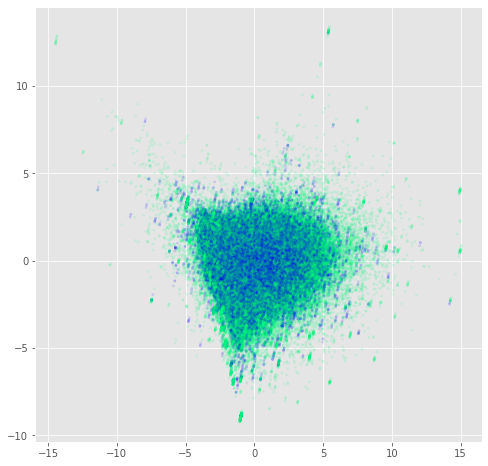

In [27]:
pca = PCA(2)
temp_X_pca_input = train_X
temp_y_pca_input = train_y

Z = pca.fit_transform(temp_X_pca_input)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Z[:,0], Z[:,1],c=temp_y_pca_input, alpha=0.1, s=5, cmap="winter")

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(2.0, 0)

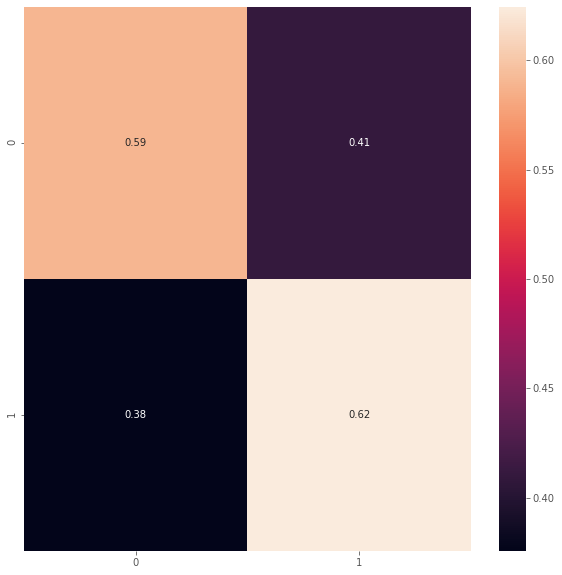

In [28]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=200, class_weight="balanced", C=0.5)
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(2.0, 0)

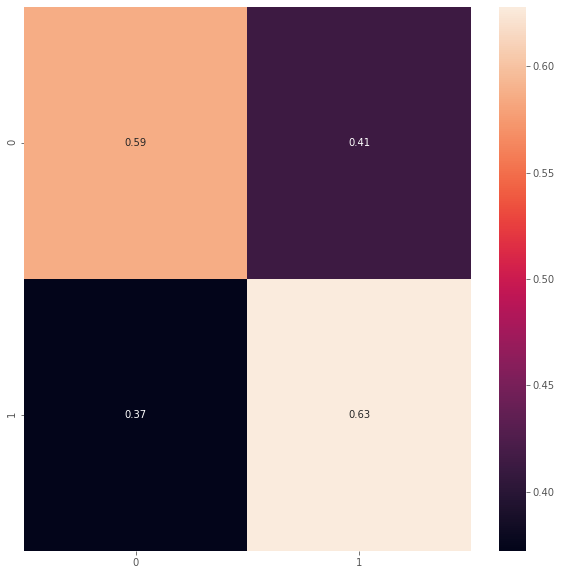

In [29]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=200, class_weight="balanced", C=5)
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_val)

y_true = y_val
y_pred = lr_y_pred
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

In [34]:
model = Sequential()
model.add(Dense(50, input_shape=(train_X.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=100)

Epoch 1/5
11795/11795 [==============================] - 30s 3ms/step - loss: 0.6041 - accuracy: 0.6731
Epoch 2/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5812 - accuracy: 0.6955
Epoch 3/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5739 - accuracy: 0.7018
Epoch 4/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5697 - accuracy: 0.7049
Epoch 5/5
11795/11795 [==============================] - 29s 2ms/step - loss: 0.5665 - accuracy: 0.7075


12286/12286 [==============================] - 16s 1ms/step
Val Loss:  0.5676828026771545 , Test Accuracy:  0.7068740725517273


(2.0, 0)

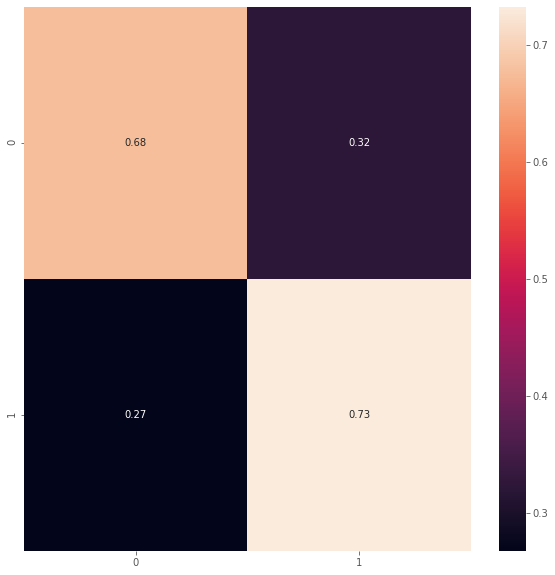

In [35]:
val_loss, val_acc = model.evaluate(X_val, y_val)
predictions = model.predict(X_val)

#assert np.all(predictions >= 0)
#assert np.all(predictions <= 1)
#accuracy = np.mean(y_val==np.squeeze((predictions >= 0.5).astype(int)))

print("Val Loss: ", val_loss, ", Test Accuracy: ", val_acc)
y_true = y_val
y_pred = np.squeeze((predictions >= 0.5).astype(int))
conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(conf_matrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

# VISUALIZATION ONLY

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def plot_silhoutte_scores(embeddings):
    range_n_clusters = [20, 50, 100, 250, 500, 1000]
    silhouette_avg = []
    for num_clusters in tqdm.tqdm(range_n_clusters):   
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(embeddings)
        cluster_labels = kmeans.labels_
        
        # silhouette score
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_avg.append(score)
        print(score)
    plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()
# plot_silhoutte_scores(user_embeddings)
# silhoutte scores reveal that user_embeddings is poor to k-means cluster on (highly overlapped): increasing K worsens the silhoutte score

In [ ]:
your_word_vector = business_embeddings[0]
recipe_word2vec.most_similar(positive=[your_word_vector], topn=1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def clean_text_column(text_column):
    non_alphanumeric = string.punctuation # constant
    text_column = text_column.str.lower()
    text_column = text_column.str.translate(str.maketrans(non_alphanumeric, " "*len(non_alphanumeric)))
    return text_column

In [ ]:
i = 17
# 10
print("Business id:", i)
print(recipe_word2vec.most_similar(positive=[business_embeddings[i]], topn=1)[0][0])
def get_words_of_business_id(business_id):
    business_id_df = reviews_df[reviews_df["business_id"]==business_id]
    review_text_column = business_id_df["review_text"]
    review_text_column = clean_text_column(review_text_column)
    review_text_column = review_text_column.apply(
        lambda x: " ".join([
            word for word in x.split(" ") 
            if word in recipe_tfidf.vocab2idx
            ])+" ")
    review_text = review_text_column.values.sum()
    review_text_set = pd.Series(review_text.split(" ")).value_counts()
    review_text_set
    print(review_text_set)

get_words_of_business_id(business_id_list[i])

In [ ]:
i = 0
print("The representative word for Restaurant", business_id_list[i], "is :\n", 
      recipe_word2vec.most_similar(positive=[business_embeddings[i]], topn=1)[0][0])
print("\nThe reviews for this restaurant are as follows:\n")
(reviews_df[reviews_df["business_id"]==business_id_list[i]]["review_text"])

In [ ]:
from sklearn.cluster import DBSCAN
eps = 3
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(business_embeddings)
business_labels = dbscan.labels_
print(len((business_labels)))
assert len(business_id_list) == len(business_labels)
print(len(set(business_labels)))

eps = 3
min_samples = 1
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(user_embeddings)
user_labels = dbscan.labels_
print(len((user_labels)))
assert len(user_id_list) == len(user_labels)

print(len(set(user_labels)))

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
business_embeddings_ = StandardScaler().fit_transform(business_embeddings)
user_embeddings_ = StandardScaler().fit_transform(user_embeddings)
pca = PCA(50)
tsne = TSNE(n_components=2, perplexity=100, n_iter=250)
Z_business = business_embeddings_
Z_business = pca.fit_transform(Z_business)
Z_business = tsne.fit_transform(Z_business)
#Z_business = umap0.fit_transform(Z_business)

pca = PCA(50)
tsne = TSNE(n_components=2, perplexity=100, n_iter=250)
Z_user = user_embeddings_
Z_user = pca.fit_transform(Z_user)
Z_user = tsne.fit_transform(Z_user)
#Z_user = umap0.fit_transform(Z_user)

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c=business_labels,cmap="Spectral")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c=user_labels,cmap="Spectral")#, label=word_labels)
axs[1].set_title("User Embeddings")
#axs[1].legend()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(10)
kmeans.fit(business_embeddings)
business_labels = kmeans.labels_
print(len((business_labels)))
print(len(set(business_labels)))

kmeans = KMeans(20)
kmeans.fit(user_embeddings)
user_labels = kmeans.labels_
print(len((user_labels)))
print(len(set(user_labels)))
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c=business_labels,cmap="tab10")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c=user_labels,cmap="tab20")#, label=word_labels)
axs[1].set_title("User Embeddings")
#axs[1].legend()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].scatter(Z_business[:,0], Z_business[:,1], alpha=0.5,s=1, c='r',cmap="tab10")
axs[0].set_title("Business Embeddings")
#from matplotlib import cm
#colormap = cm.hsv(range(20))


axs[1].scatter(Z_user[:,0], Z_user[:,1], alpha=0.5,s=1, c='r',cmap="tab20")#, label=word_labels)
axs[1].set_title("User Embeddings")

In [ ]:
def get_label_data(labels, id_list, id2vec, id_column_name, reviews_df):
    labels_set = set(labels)
    labels_representative_words = []
    labels_representative_embeddings = []
    labels_vocab_frequency = []
    for label in labels_set:
        temp_idxs = np.where(np.array(labels)==label)[0]
        embeddings_group = []
        group_vocab = " "
        for temp_idx in temp_idxs:
            temp_id = id_list[temp_idx]
            #for key in id2vec[temp_id]: embeddings_group += id2vec[(id_list[temp_idx])][key];
            ##
            temp_id_df = reviews_df[reviews_df[id_column_name]==temp_id]
            review_text_column = temp_id_df["review_text"]
            review_text_column = clean_text_column(review_text_column)
            review_text_column = review_text_column.apply(
                lambda x: " ".join([
                    word for word in x.split(" ") 
                    if word in recipe_tfidf.vocab2idx
                    ])+" ")
            
            combined_review_texts_of_id = review_text_column.values.sum() # get all re
            group_vocab += (combined_review_texts_of_id+" ")
            ##
        group_vocab_list = group_vocab.split(" ")
        group_vocab_list = [word for word in group_vocab_list if word != ""]
        group_vocab_frequency = pd.Series(group_vocab_list).value_counts()
        labels_vocab_frequency.append(group_vocab_frequency)


        #embeddings_group = np.array(embeddings_group)
        #labels_representative_embedding = embeddings_group.mean(axis=0)
        #labels_representative_embeddings.append(labels_representative_embedding)

        #labels_representative_word = recipe_word2vec.most_similar(positive=[labels_representative_embedding], topn=1)
        #labels_representative_words.append(labels_representative_word[0][0])


    return labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency
#output_labels_data = get_label_data(business_labels, business_id_list, business_user2reviewTextVec, "business_id", reviews_df)
#labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency = output_labels_data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import scipy

In [ ]:
learned_mapping = dict(zip(list(recipe_tfidf.vocab2idx.keys()),list(range(len(recipe_tfidf.vocab2idx)))))

In [ ]:
label_column_name = "business_label"
business_labeler = pd.DataFrame()
business_labeler[label_column_name] = business_id_list
business_labeler[label_column_name] = business_labels
temp_reviews_df = reviews_df.merge(business_labeler, on=[label_column_name])

In [ ]:
label_column_name = "user_label"
user_labeler = pd.DataFrame()
user_labeler["user_id"] = user_id_list
user_labeler[label_column_name] = user_labels
temp_reviews_df = reviews_df.merge(user_labeler, on=["user_id"])

In [ ]:
### Move to Vectorizer_Builder (collapser version 1)
learned_mapping = dict(zip(list(recipe_tfidf.vocab2idx.keys()),list(range(len(recipe_tfidf.vocab2idx)))))

temp_labels = list(pd.unique(temp_reviews_df[label_column_name]))

review_text_column_ = []

for label in temp_labels:
    label_all_text = ""
    temp_reviews_df_label = temp_reviews_df[temp_reviews_df[label_column_name]==label]
    temp_review_text_column = temp_reviews_df_label["review_text"]
    temp_review_text_column = clean_text_column(temp_review_text_column)
    for row in tqdm.tqdm(list(temp_review_text_column.values)):
        label_all_text += (" "+row)
    review_text_column_.append(label_all_text)
learned_tv = Pipeline([('count', CountVectorizer(vocabulary=learned_mapping)),
                       ('tfidf', TfidfTransformer())])
learned_tv.fit(review_text_column_)
tv_output_collapsed = learned_tv.transform(review_text_column_)
#tv_output_collapsed = tv_output_collapsed.tocsc().A

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_top_n_from_vector(feature_names, sorted_items, top_n=10):
    sorted_items = sorted_items[:top_n]
    
    score_vals = []
    feature_vals = []
    for idx, score in sorted_items:
        score_vals.append(round(score,3))
        feature_vals.append(feature_names[idx])
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results

In [ ]:
# Now doing USERS!

In [ ]:
feature_names = learned_tv.named_steps["count"].get_feature_names()
i = 19
print("Group", temp_labels[i], "Keywords:" )
output_label_temp = learned_tv.transform([review_text_column_[i]])
sorted_items = sort_coo(output_label_temp.tocoo())
keywords = extract_top_n_from_vector(feature_names, sorted_items, 50)
keywords
# 7 = pizza, italian
# 4 = sweets (chocolate, cookies, cake, cream)
# 5 = seafood?

# user7 = asian
# user0 = sweets

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
a = np.array([
    [0.090909, 0.1111111, 0.5],
    [0.090909, 0, 0],
    [0.11111111, 0, 0],
    [0.11111111, 0, 0],
    [0.11111111, 0.1818181818, 0],
    [0.11111111, 0.090909, 0],
    [0.25, 0, 0]
])
a_scaled = MinMaxScaler().fit_transform(a.T).T


In [ ]:
a_scaled

In [ ]:
np.std(a_scaled,axis=1,ddof=0)

In [ ]:
### Move to Vectorizer_Builder (collapser version 2)

#temp_reviews_df.sort_values(["business_label"],inplace=True)

temp_labels = list(pd.unique(temp_reviews_df[label_column_name]))

review_text_column = temp_reviews_df["review_text"]
review_text_column = clean_text_column(review_text_column)

learned_tv = Pipeline([('count', CountVectorizer(vocabulary=learned_mapping)),
                       ('tfidf', TfidfTransformer())])
learned_tv.fit(review_text_column)
tv_output = learned_tv.transform(review_text_column)

tv_output_collapsed = []
for temp_label in temp_labels:
    temp_label_tv_output_collapsed = tv_output[np.where(temp_reviews_df[label_column_name]==temp_label)[0]].mean(axis=0)
    tv_output_collapsed.append(np.squeeze(temp_label_tv_output_collapsed.A,0))
tv_output_collapsed = np.array(tv_output_collapsed)

In [ ]:
ind = np.argsort(tv_output_collapsed, axis=1)
[recipe_tfidf.idx2vocab[i] for i in ind[:,-1]]

In [ ]:
def get_label_data(labels, id_list, id2vec, id_column_name, reviews_df):
    labels_set = set(labels)
    labels_representative_words = []
    labels_representative_embeddings = []
    labels_vocab_frequency = []
    for label in labels_set:
        temp_idxs = np.where(np.array(labels)==label)[0]
        temp_ids = [id_list[temp_idx] for temp_idx in temp_idxs]
        temp_label_df = reviews_df[reviews_df[id_column_name].isin(temp_ids)]
        review_text_column = temp_label_df["review_text"]
        review_text_column = clean_text_column(review_text_column)
        learned_mapping = dict(zip(list(recipe_tfidf.keys()),list(range(len(recipe_tfidf)))))
        # learned_cv = CountVectorizer(vocabulary=learned_mapping)
        # cv_output = learned_cv.transform(review_text_column)
        # cv_output = cv_output.tocsc()
        # scipy.sparse.csc_matrix.sum(cv_output, axis=0)

        learned_tv = TfidfVectorizer(vocabulary=learned_mapping)
        tv_output = learned_tv.transform(review_text_column)
        tv_output.

        review_text_column
        for temp_idx in temp_idxs:
            temp_id = id_list[temp_idx]
            #for key in id2vec[temp_id]: embeddings_group += id2vec[(id_list[temp_idx])][key];
            ##
            temp_id_df = reviews_df[reviews_df[id_column_name]==temp_id]
            review_text_column = temp_id_df["review_text"]
            review_text_column = clean_text_column(review_text_column)
            review_text_column = review_text_column.apply(
                lambda x: " ".join([
                    word for word in x.split(" ") 
                    if word in recipe_tfidf.vocab2idx
                    ])+" ")
            
            combined_review_texts_of_id = review_text_column.values.sum() # get all re
            group_vocab += (combined_review_texts_of_id+" ")
            ##
        group_vocab_list = group_vocab.split(" ")
        group_vocab_list = [word for word in group_vocab_list if word != ""]
        group_vocab_frequency = pd.Series(group_vocab_list).value_counts()
        labels_vocab_frequency.append(group_vocab_frequency)


        #embeddings_group = np.array(embeddings_group)
        #labels_representative_embedding = embeddings_group.mean(axis=0)
        #labels_representative_embeddings.append(labels_representative_embedding)

        #labels_representative_word = recipe_word2vec.most_similar(positive=[labels_representative_embedding], topn=1)
        #labels_representative_words.append(labels_representative_word[0][0])


    return labels_set, labels_representative_words, labels_representative_embeddings, labels_vocab_frequency

In [ ]:
labels_set, labels_representative_words, labels_representative_embeddings = get_label_data(user_labels, user_id_list, user_business2reviewTextVec)
labels_representative_words

In [ ]:
temp_business_cluster_mapper = pd.DataFrame()
temp_business_cluster_mapper["business_id"] = business_id_list
temp_business_cluster_mapper["business_id_regrouped"] = business_labels

temp_user_cluster_mapper = pd.DataFrame()
temp_user_cluster_mapper["user_id"] = user_id_list
temp_user_cluster_mapper["user_id_regrouped"] = user_labels

temp_reviews_df = reviews_df.copy()
temp_reviews_df = temp_reviews_df.merge(temp_business_cluster_mapper, on=["business_id"])
temp_reviews_df = temp_reviews_df.merge(temp_user_cluster_mapper,  on=["user_id"])

temp_reviews_df = 

In [ ]:
temp_reviews_df

In [ ]:
# end goal (just for scatterplotting)
# create a 2D scatterplot from (PCA, TSNE)
# with grouped adjacent clusters (size>20, n_cluster<50) with representative word being adjacent
# these clusters need not be made after the creation of the 2D scatterplotting,
# for business and user (business easier, but user more useful)
#
# but how make words spacially logical? we have the pita-naan july4th word2vec model...
# given (for user or business) 
# # a bank of review sentences, clean, split, remove stop words, keep only food-related words (how do that? with just ingredients, or names too (introduces the risk of emotional words))
# given (for user or business) a bank of review sentences after data-cleaning, get a representative vector-point 
# # (which is then put through PCA/TSNE for a 2D scatterplot)
# cluster group these user businesses or vector points



# why do embeddings when words are faster 
# to embedding
# micro 
# # DBSCAN
# # Eventually, 2D
# macro 
# # 2D scatterplot (TSNE)
# # only here can tf-idf be applied